In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import network_gathering_node, memory_summarizer_node, event_summarizer_node, attack_and_exploitation_node, exploitation_manager_node, firewall_node, save_iteration_node
from configuration.state import HoneypotStateReact
from configuration import memory
nest_asyncio.apply()
import benchmark.benchmark as b



def display_graph(graph, width=300, height=300):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-3.5-turbo",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:
# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


In [3]:
def should_continue_from_firewall(state: HoneypotStateReact) -> Literal["tools_firewall", "save_iteration"]:
    if hasattr(state, 'firewall_action'):
        return "tools_firewall"
    
    return "save_iteration"

In [4]:
def build_react_graph():
    graph = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    graph.add_node("network_gathering", network_gathering_node.network_gathering)
    graph.add_node("memory_summarizer", memory_summarizer_node.memory_summarizer)
    graph.add_node("event_summarizer", event_summarizer_node.event_summarizer)
    graph.add_node("attack_graph_inference", attack_and_exploitation_node.attack_graph_inference)
    graph.add_node("exploitation_manager", exploitation_manager_node.exploitation_manager)
    graph.add_node("firewall_executor", firewall_node.firewall_executor)
    graph.add_node("save_iteration", save_iteration_node.save_iteration)
    graph.add_node("tools_firewall", firewall_node.tools_firewall)
 

    # Define execution order
    graph.add_edge(START, "network_gathering")
    graph.add_edge(START, "memory_summarizer")
    graph.add_edge("network_gathering", "event_summarizer")
    graph.add_edge("event_summarizer", "attack_graph_inference")
    graph.add_edge(["attack_graph_inference", "memory_summarizer"], "exploitation_manager")
    graph.add_edge("exploitation_manager", "firewall_executor")
    graph.add_conditional_edges("firewall_executor", should_continue_from_firewall)
    graph.add_edge("tools_firewall", "save_iteration")
    graph.add_edge("save_iteration", END)

        
    return graph.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:52765/devtools/browser/8c7f4c63-a46f-4564-bd98-08f3bf9fd8b2
INFO:pyppeteer.launcher:terminate chrome process...


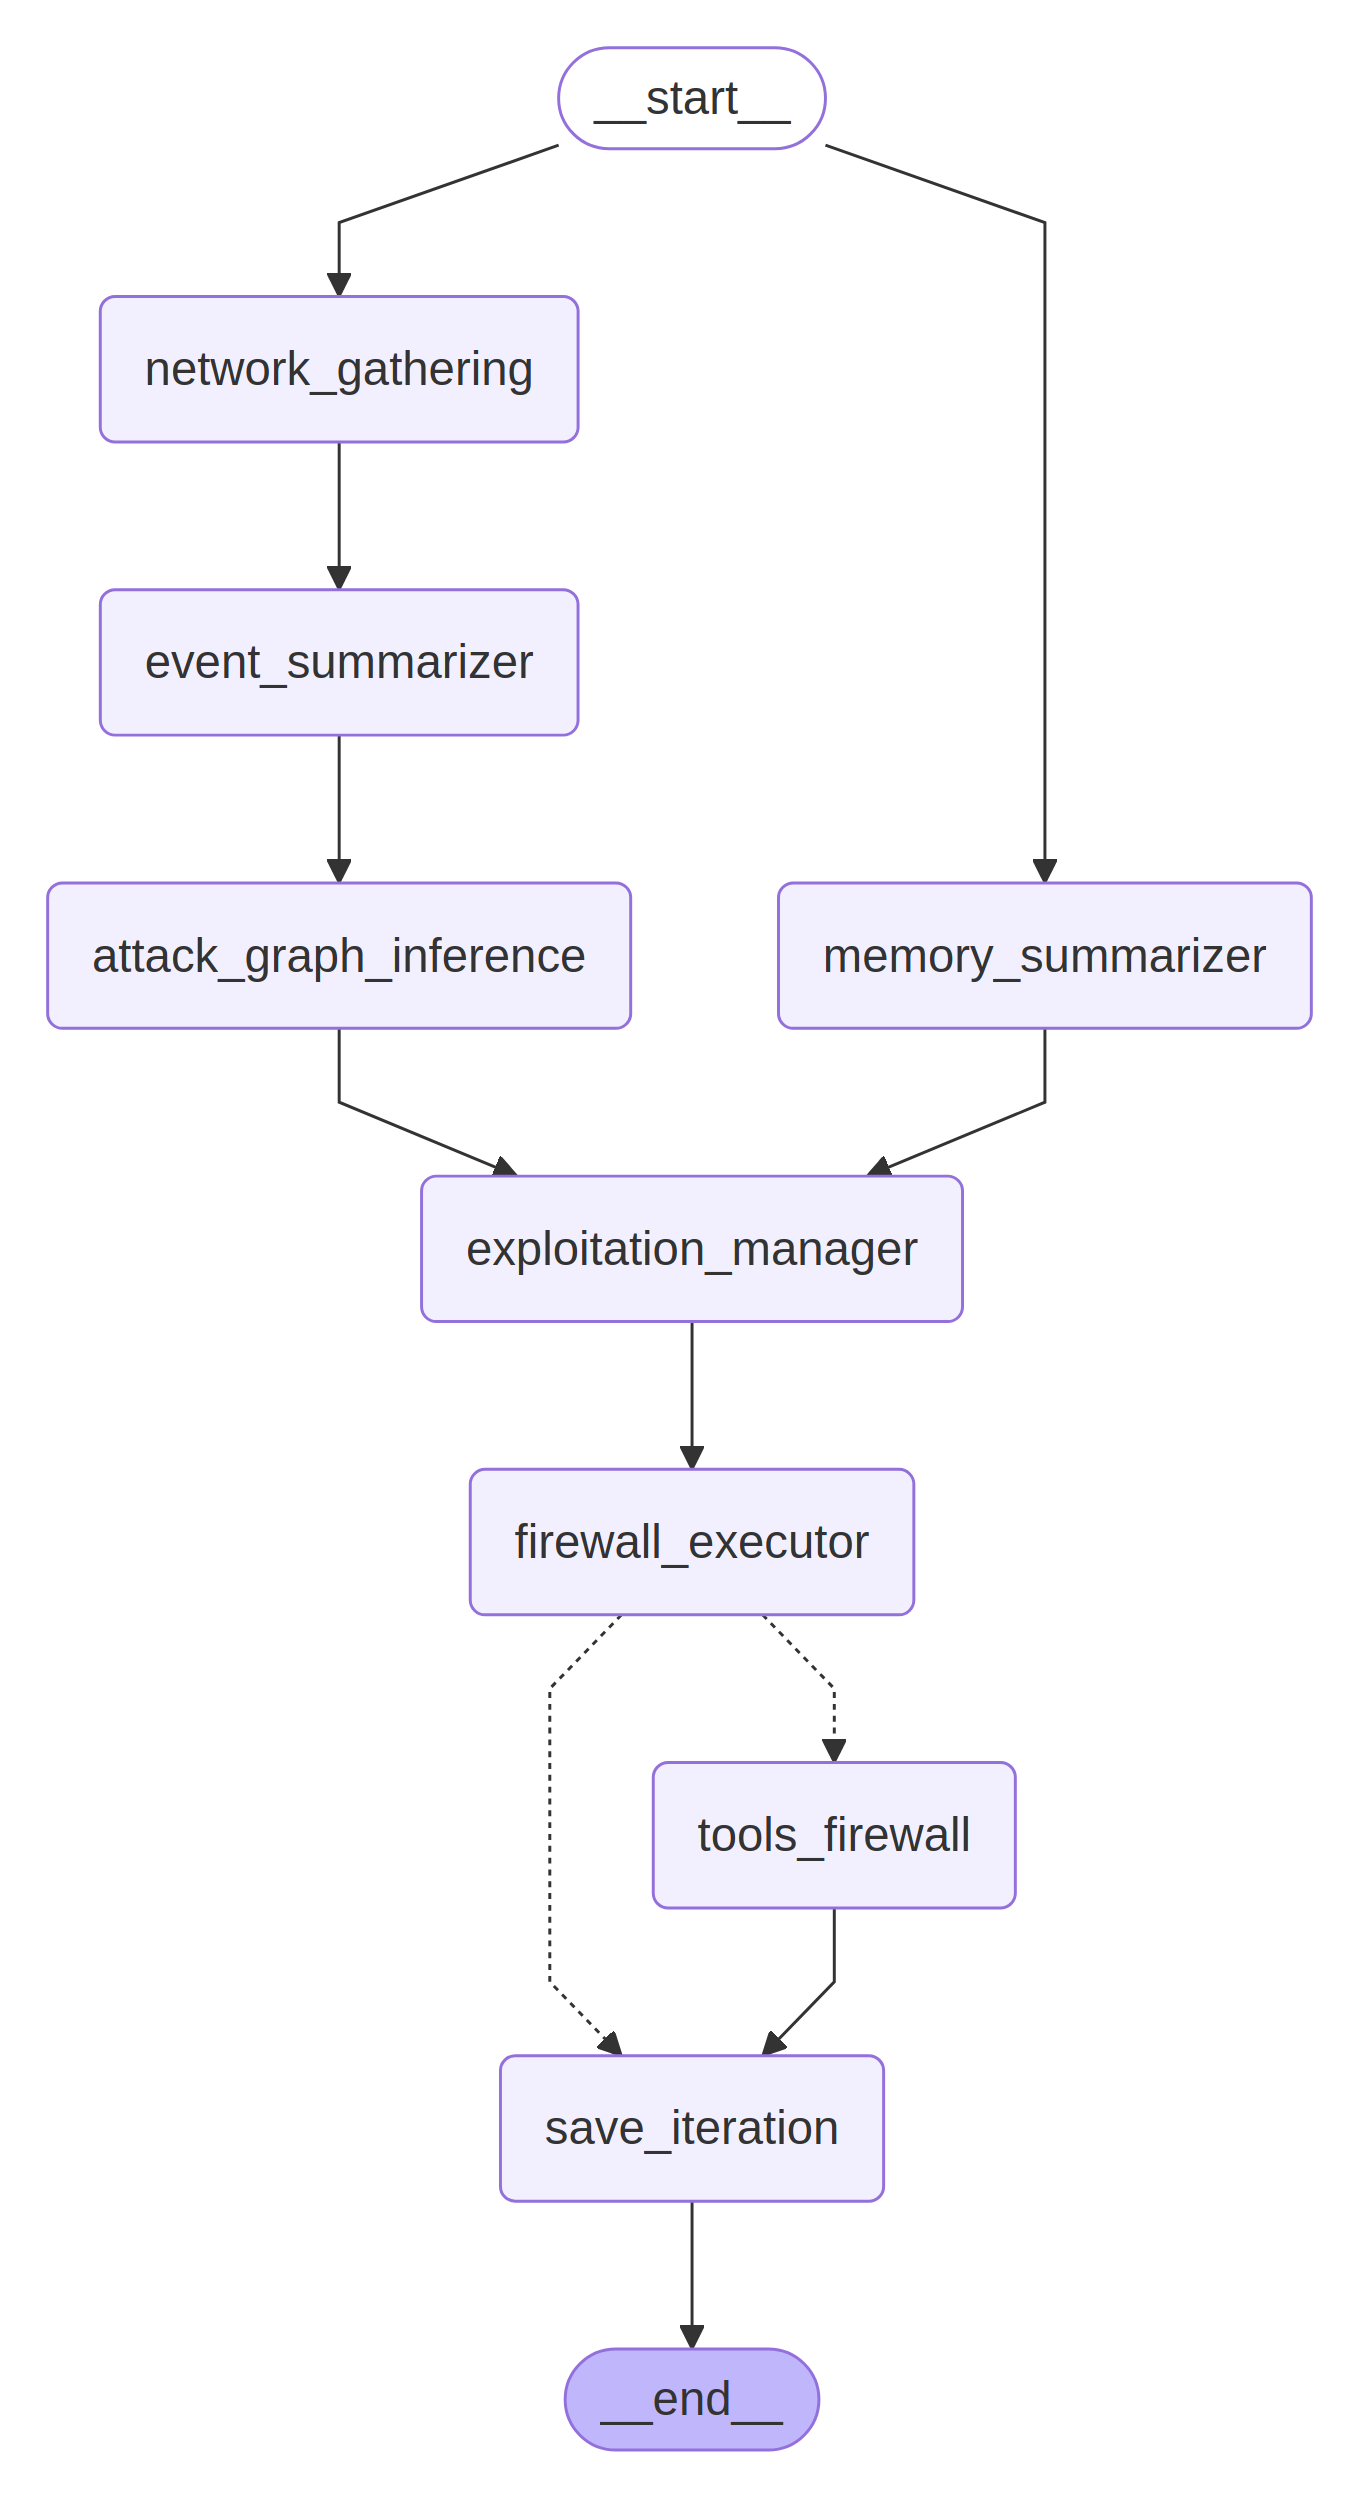

In [5]:
graph = build_react_graph()
display_graph(graph)

## Single Iteration

In [6]:
episodic_memory = memory.EpisodicMemory()


In [7]:
responses = []
for i in range(2):
    initial_state = HoneypotStateReact(
        messages=[]
    )
    response = await graph.ainvoke(initial_state, config={"configurable": {"store" : episodic_memory, "prompt":"fast", "time_window":2, "epoch_num":i}})
    responses.append(response)

INFO:nodes.memory_summarizer_node:Memory Agent
INFO:nodes.memory_summarizer_node:0
INFO:nodes.memory_summarizer_node:
# Memory Summarizer Agent — Exploitation Plan Focus (Epoch-Aware)

## ROLE
You summarize the last epoch's exploitation plan specifically for the Exploitation Manager Agent, and maintain a compact, epoch-indexed history log.

## INPUTS
- Exploitation plan episodic memory of the last epoch: []
- Last episodic memory summary (may include prior epoch log): []
- Current epoch number: 0

## SUMMARY RULES
1. PRIORITIZE (for the current epoch only):
   a. Which honeypot was exposed (IP, service).
   b. Exploitation level before → after (if changed).
   c. Whether policy rules were followed (e.g., single exposure, no re-exposure of 100%).
   d. Any rotation/diversity decisions.
   e. Any anomalies or deviations.

2. BE CONCISE:
   - Use ≤ 3 short bullets for the current epoch OR a single sentence if enough.
   - Avoid raw logs, low-level firewall details, unchanged info, or spec

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes.network_gathering_node:Network gathering Node
INFO:nodes.event_summarizer_node:Summarizer Agent
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


CancelledError: 

In [12]:
for response in responses:
    for m in response['messages']:
        m.pretty_print()

================================ Human Message =================================

No episodic memory or summaries available for the last epoch. No current epoch number provided.
================================ Human Message =================================

Threat Overview:
- Attack Volume: 0 alerts over the last 2 minutes
- High-Severity Alerts: No evidence found.
- Primary Attack Types: No evidence found.
- Threat Level: Low (no recent alerts)

Source Analysis:
- No evidence found.

Target Analysis:
- cve-2014-6271-web-1 (172.20.0.7):
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.
- cve-2015-5254-activemq-1 (172.20.0.6):
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise Indicators: No evidence found.
- cve-2021-22205-gitlab-1-proxy (172.20.0.10):
  - Targeted Services: No evidence found.
  - Honeypot Engagement: No evidence found.
  - Compromise In

In [10]:
for i in episodic_memory.get_recent_iterations():
    for k,v in i.value.items():
        print(f"Key: {k}\nValue: {v}")

Key: id
Value: iteration_1
Key: iteration_number
Value: 1
Key: timestamp
Value: 1754574383
Key: datetime
Value: 2025-08-07T15:46:23.627252
Key: memory_context
Value: No prior episodic memory or summary exists. This epoch represents the initial honeypot system state. There are no changes, progressions, or notable events from a previous state to summarize.
Key: currently_exposed
Value: {}
Key: rules_added
Value: []
Key: honeypots_exploitation
Value: {}
Key: lockdown_status
Value: True
Key: rules_removed
Value: []
Key: firewall_reasoning
Value: 
Key: inferred_attack_graph
Value: {}
Key: reasoning_inference
Value: Step-by-step reasoning justifying any changes: 
- The event summary indicates zero alerts in the last 2 minutes. There is no high-severity alert or primary attack type reported. 
- Explicitly, 'No honeypots available; no analysis possible' and 'Available Honeypots: []' indicate there are no deployed or discoverable honeypots. 
- With zero activity and no honeypots, there can be n

## Benchmark

In [ ]:
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 20,
            "attack_duration": 200,
            "monitor_accumulation_wait": 50,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "All_exploitable_eve"
        }
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages=[]
)
responses = []
async def my_agent_executor(epoch_num: int):
    response = await graph.ainvoke(initial_state, config={
        "configurable": 
            {
            "store" : episodic_memory, 
            "time_window":2, 
            "prompt":"eve",
            "epoch_num": epoch_num
            }
        }
    )
    responses.append(response)
    return response
    

results = runner.run(my_agent_executor)

INFO:benchmark.benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.benchmark.Orchestrator:
INFO:benchmark.benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.benchmark.Orchestrator:============================================================

INFO:benchmark.benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.benchmark.Atta

In [13]:
for i, response in enumerate(responses):
    
    print("=" * 130)
    print(f"Epoch: {i+1}")
    for m in response['messages']:
        m.pretty_print()
    print("-" * 130)

Epoch: 1
================================ Human Message =================================

No episodic memory or prior summary provided for this epoch. No changes or exploitation plan information available.
================================ Human Message =================================

Threat Overview:
- Attack Volume: 65 alerts over 2 minutes
- High-Severity Alerts: No RCE or critical compromise attempts identified; all alerts are port scans or attempted service enumerations (severity/priority 2)
- Primary Attack Types:
  - Port scans (NMAP -sS) targeting multiple TCP ports (443, 22, 3306, 8080, etc.)
  - Service scan alerts for SSH (22/tcp), MySQL (3306/tcp), MSSQL (1433/tcp)
- Threat Level: Medium (consistent, automated probing and service enumeration, no direct exploits or privilege escalation observed)

Source Analysis:
- Top Attacking IPs:
  - 192.168.100.2, 65

Target Analysis:
- cve-2014-6271-web-1 (172.20.0.5):
  - Targeted Services: 1433/tcp, 51820/tcp, 139/tcp, 3306/tcp, 8